### DeepKriging with Preferential Sampling Adjustment

We will test our pref-sampling adjustment (new loss function in DeepKriging) on a 50x50 grid of synthetic data.

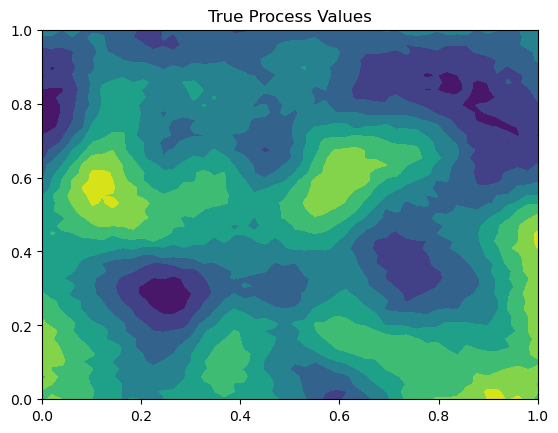

In [28]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from custom_dk_imports import DeepKrigingMLP
from custom_dk_imports import Trainer

np.random.seed(23)
torch.manual_seed(23)
torch.cuda.manual_seed(23)
torch.cuda.manual_seed_all(23)
torch.backends.cudnn.deterministic = True

N = 50
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # 2D coordinates

def exponential_kernel(s1, s2, length_scale):
    sqdist = np.sum(s1**2, axis=1).reshape(-1, 1) + np.sum(s2**2, axis=1) - 2 * np.dot(s1, s2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

length_scale = 0.1
cov_matrix = exponential_kernel(grid_points, grid_points, length_scale)
noise_var = 0.01  # Nugget variance
nugget = np.eye(grid_points.shape[0]) * noise_var
cov_matrix += nugget  # Covariance matrix with noise

mean = np.zeros(grid_points.shape[0])
process_values = np.random.multivariate_normal(mean, cov_matrix)

# Visualize the process values
process_values_grid = process_values.reshape(N, N)
plt.contourf(X, Y, process_values_grid)
plt.title("True Process Values")
plt.show()


In [29]:
# Define necessary parts from nn.py
class DeepKrigingEmbedding3d(nn.Module):
    def __init__(self, K: int):
        super(DeepKrigingEmbedding3d, self).__init__()
        self.K = K
        self.num_basis = [(9*2**(h-1)+1)**2 for h in range(1,self.K+1)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        knots_1d = [torch.linspace(0, 1, int(np.sqrt(i))).to(self.device) for i in self.num_basis]
        N = s.shape[0]
        phi = torch.zeros(N, sum(self.num_basis)).to(self.device)
        K = 0
        for res, num_basis_res in enumerate(self.num_basis):
            theta = 1 / np.sqrt(num_basis_res) * 2.5
            knots_s1, knots_s2 = torch.meshgrid(knots_1d[res], knots_1d[res], indexing='ij')
            knots = torch.stack((knots_s1.flatten(), knots_s2.flatten()), dim=1).to(self.device)
            d = torch.cdist(s, knots) / theta
            mask = (d >= 0) & (d <= 1)
            weights = torch.zeros_like(d)
            weights[mask] = ((1 - d[mask]) ** 6 * (35 * d[mask] ** 2 + 18 * d[mask] + 3) / 3)
            phi[:, K:K + num_basis_res] = weights
            K += num_basis_res
        return phi

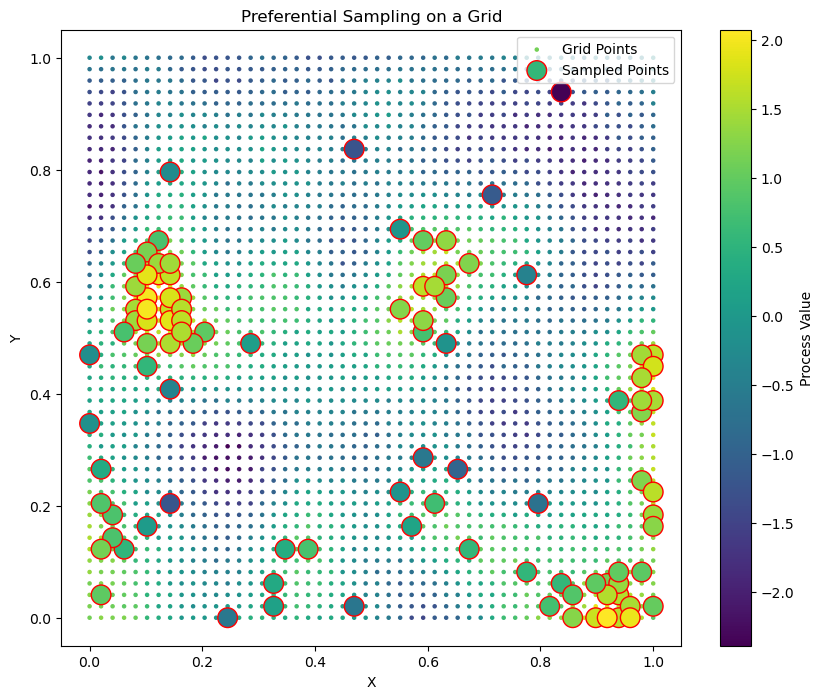

In [30]:
true_scaling = 2.0  # Example true scaling parameter
true_intercept = -2  # Example true intercept parameter

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def preferential_sampling(points, values, n_samples=50):
    # define the likelihood of sampling a location as a function of its value
    probabilities = softmax(true_scaling*values + true_intercept) # abs value of values?
    # Points with higher probabilities (derived from higher values) are more likely to be sampled
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    # observed_indices = sampled_indices
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
observed_points, observed_values, observed_indices = preferential_sampling(grid_points, process_values, n_samples=100)
non_observed_indices = np.setdiff1d(np.arange(grid_points.shape[0]), observed_indices)
non_observed_points = grid_points[non_observed_indices]
non_observed_values = process_values[non_observed_indices]

# plot the sampled points:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(grid_points[:, 0], grid_points[:, 1], c=process_values, cmap='viridis', s=5, label='Grid Points')
plt.scatter(observed_points[:, 0], observed_points[:, 1], c=observed_values, cmap='viridis', edgecolor='red', s=200, label='Sampled Points', marker='o')
plt.colorbar(scatter, label='Process Value')
plt.title("Preferential Sampling on a Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [31]:
from sklearn.model_selection import train_test_split

# Define M as an indicator array for the entire grid
M = np.zeros(len(grid_points))
M[observed_indices] = 1  # Mark observed points

s_train, s_val, y_train, y_val, M_train, M_val = train_test_split(grid_points, process_values, M, test_size=0.2, random_state=2023)
s_test = grid_points  # Use the full grid as the test set

# Convert M_train and M_val back to torch tensors
M_train = torch.tensor(M_train, dtype=torch.float32)
M_val = torch.tensor(M_val, dtype=torch.float32)

# Define model parameters
num_hidden_layers = 1
hidden_dims = 100
K = 3  # embedding layer will update K based on DeepKrigingEmbedding3d

# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding3d(K)
input_dim = sum(embedding_layer.num_basis)  # This should match 1830

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)
s_all_tensor = torch.tensor(grid_points, dtype=torch.float32)
# print(s_train_tensor)

embedding_layer.eval()
# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)
phi_all = embedding_layer(s_all_tensor)

# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(process_values, dtype=torch.float32).view(-1, 1)
y_all_tensor = torch.tensor(process_values, dtype=torch.float32).view(-1, 1)

deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='relu')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

from custom_dk_imports import NewLoss
trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 0.001},
    loss_fn=NewLoss(s_all=grid_points, observed_indices=observed_indices, y_all=process_values),
    # loss_fn=nn.MSELoss(),
    M_train=M_train,
    M_val=M_val,
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_all).cpu().numpy()
    

Training started:

Epoch 1/100
Learning rate: 0.001000
0s for 63 steps - 3ms/step - loss 1.1101
Validation:
0s - loss 0.6951

Epoch 2/100
Learning rate: 0.001000
0s for 63 steps - 2ms/step - loss 0.6937
Validation:
0s - loss 0.6052

Epoch 3/100
Learning rate: 0.001000
0s for 63 steps - 2ms/step - loss 0.6731
Validation:
0s - loss 0.6025

Epoch 4/100
Learning rate: 0.001000
0s for 63 steps - 1ms/step - loss 0.6596
Validation:
0s - loss 0.6020

Epoch 5/100
Learning rate: 0.001000
0s for 63 steps - 1ms/step - loss 0.6669
Validation:
0s - loss 0.6049

Epoch 6/100
Learning rate: 0.001000
0s for 63 steps - 1ms/step - loss 0.6662
Validation:
0s - loss 0.6057

Epoch 7/100
Learning rate: 0.001000
0s for 63 steps - 1ms/step - loss 0.6578
Validation:
0s - loss 0.6074

Epoch 8/100
Learning rate: 0.001000
0s for 63 steps - 2ms/step - loss 0.6655
Validation:
0s - loss 0.6059

Epoch 9/100
Learning rate: 0.001000
0s for 63 steps - 1ms/step - loss 0.6691
Validation:
0s - loss 0.6060

Epoch 10/100
Learn

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=0.1)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

gp.fit(s_train[M_train.numpy().astype(bool)], y_train[M_train.numpy().astype(bool)])   
y_pred_gp, y_std_gp = gp.predict(grid_points, return_std=True)

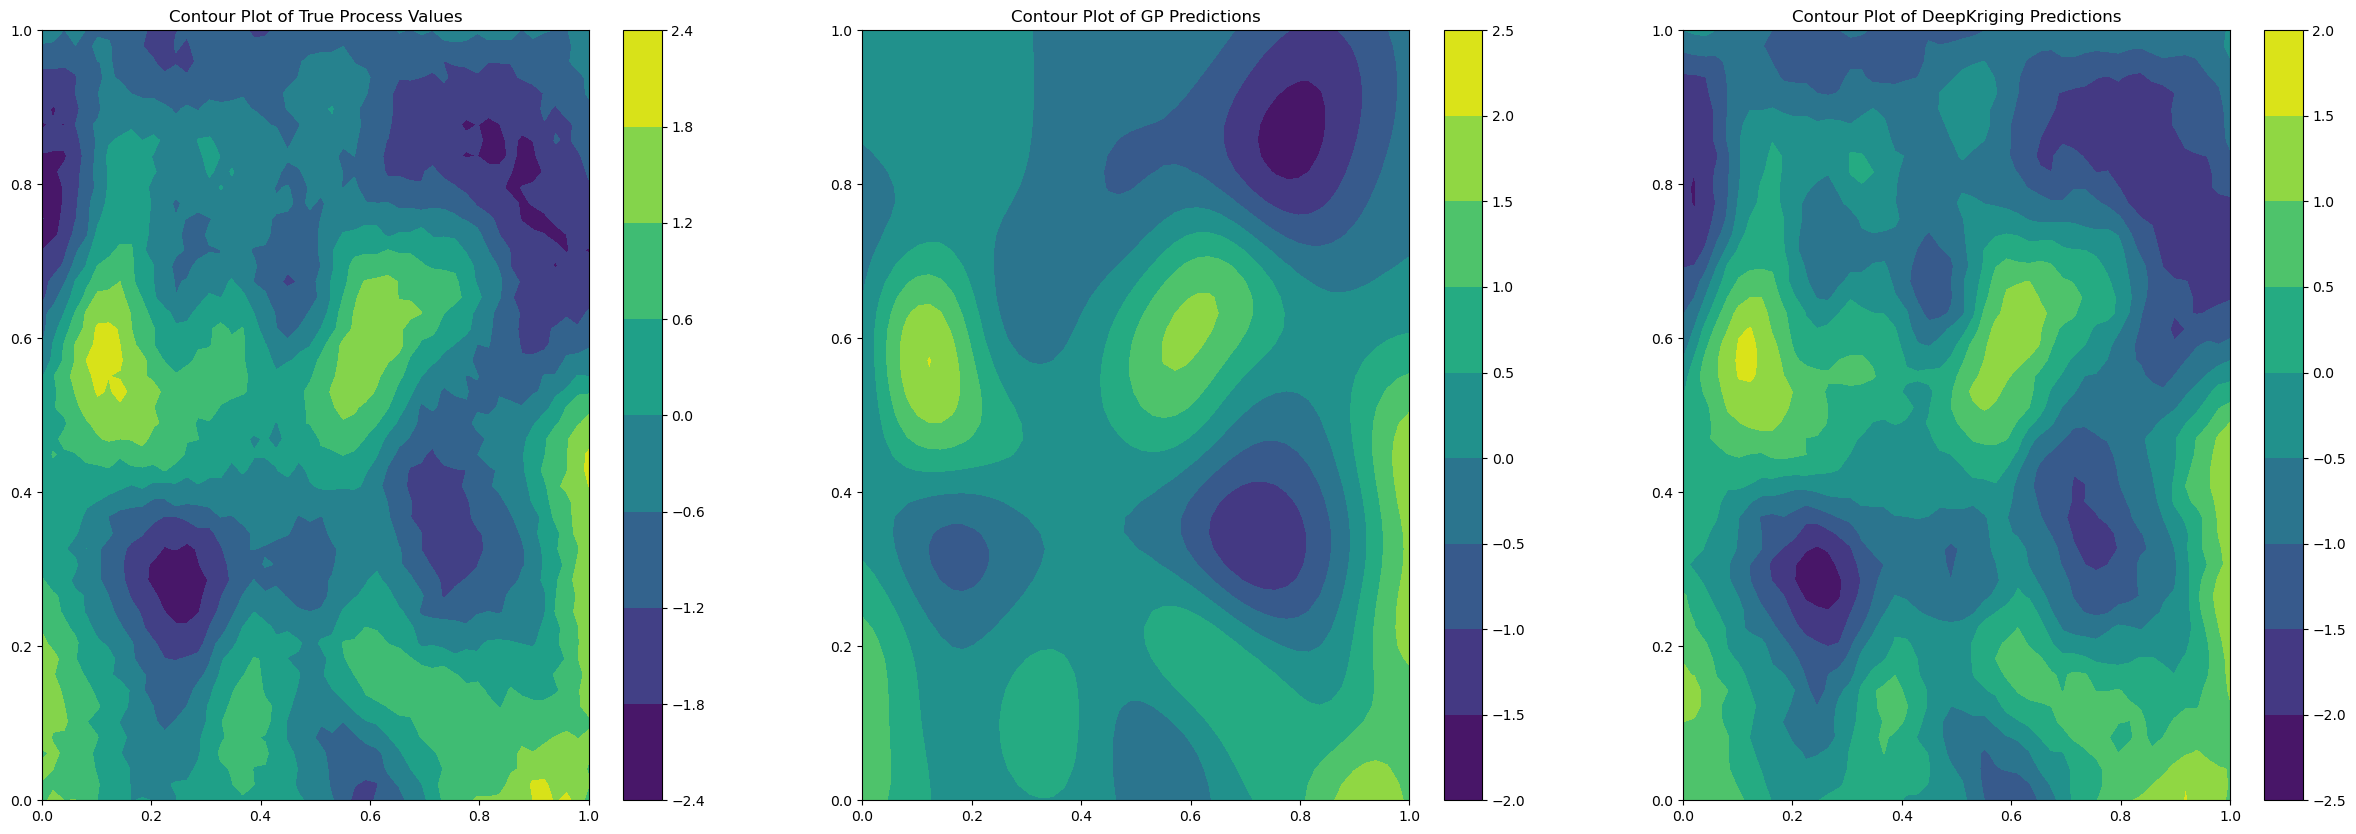

In [33]:
# from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0, 0])

contour1 = ax.contourf(X, Y, process_values_grid, cmap='viridis')
cbar1 = plt.colorbar(contour1, ax=ax)
ax.set_title("Contour Plot of True Process Values")

ax = plt.subplot(gs[0, 1])
# # Plot DeepKriging predictions directly on the test points
contour2 = ax.contourf(X, Y, y_pred_gp.reshape(*X.shape), cmap='viridis')
cbar2 = plt.colorbar(contour2, ax=ax)
ax.set_title("Contour Plot of GP Predictions")

ax = plt.subplot(gs[0, 2])
# # Plot GP predictions directly on the test points
contour3 = ax.contourf(X, Y, y_pred_deepkriging.reshape(*X.shape).squeeze(), cmap='viridis')
cbar3 = plt.colorbar(contour3, ax=ax)
ax.set_title("Contour Plot of DeepKriging Predictions")



plt.show()



plt.show()

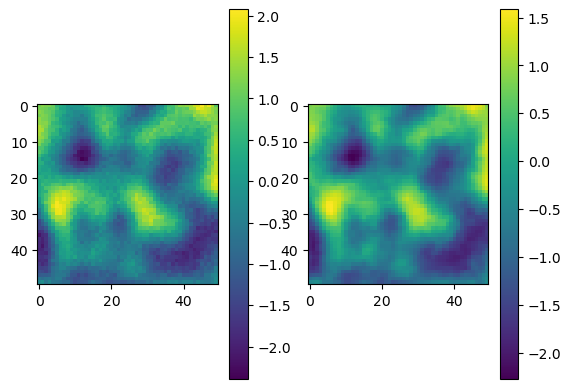

In [34]:
# fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(process_values_grid)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y_pred_deepkriging.reshape((50,50)))
plt.colorbar()


In [35]:
np.mean((process_values_grid - y_pred_deepkriging.reshape((50, 50)))**2)

0.04883622511959329

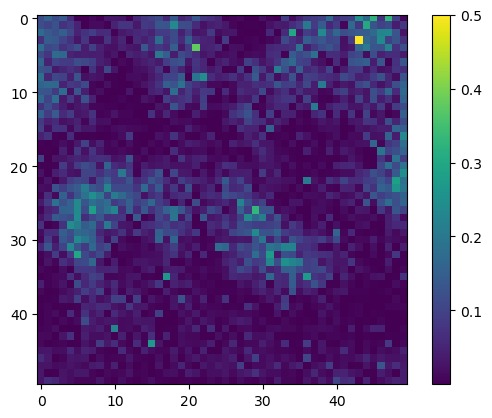

In [36]:
error = (process_values_grid - y_pred_deepkriging.reshape(*X.shape))**2

plt.imshow(error, vmax=0.5)
plt.colorbar()

In [37]:
with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_test).cpu().numpy()

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE and MAPE for DeepKriging (Model 2)
rmse_deepkriging = rmse(y_test.numpy(), y_pred_deepkriging)
mape_deepkriging = mape(y_test.numpy(), y_pred_deepkriging)
print(f"RMSE (DeepKriging): {rmse_deepkriging}")
print(f"MAPE (DeepKriging): {mape_deepkriging}")

# Calculate RMSE and MAPE for Basic GP
rmse_gp = rmse(y_test.numpy(), y_pred_gp)
mape_gp = mape(y_test.numpy(), y_pred_gp)
print(f"RMSE (GP): {rmse_gp}")
print(f"MAPE (GP): {mape_gp}")

# MSE is now pretty high... :(((

RMSE (DeepKriging): 0.2209891974925995
MAPE (DeepKriging): 90.34521579742432
RMSE (GP): 1.1922058143276706
MAPE (GP): 375.53501399018427


In [38]:
# pref sample more points on both extreme positive and negative values

